# Домашнее задание (Neural Style Transfer)
---------------------------------------

## Задание:
Разделить картинку на две части и перенести на нее два разных стиля: отдать нейросети две картинки стиля, и она внутри себя (скорее всего, внутри функции потерь) должна разделить входную картинку на две части и к одной части применить один стиль, а к другой - второй.

## 1. Установка зависимостей.

In [1]:
import os
import copy
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.optim as optim
from google.colab import drive
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

## 2. Загрузка изображений.

Я буду загружать изображения, хранящиеся на Google Drive. Для этого необходимо подключить его к Google Colaboratory:

In [2]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Загрузим исходное изображение и изображения стилей:

In [3]:
'''
В лекции говорилось, что в качестве входного изображения в большинстве случаев берется контент-изображение, 
так и сделаем:
'''
path_content_image = os.path.join('/content/gdrive/MyDrive/DLS/NST/', 'sunflowers.jpg')
path_input_image = os.path.join('/content/gdrive/MyDrive/DLS/NST/', 'sunflowers.jpg')
path_style_image1 = os.path.join('/content/gdrive/MyDrive/DLS/NST/', 'sunflowers_mone.jpg')
path_style_image2 = os.path.join('/content/gdrive/MyDrive/DLS/NST/', 'sunflowers_van_gog.jpg')

In [4]:
content_image = Image.open(path_content_image)
input_image = Image.open(path_input_image)
style_image1 = Image.open(path_style_image1)
style_image2 = Image.open(path_style_image2)

(1800, 1200)


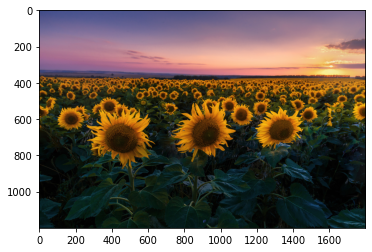

In [ ]:
# Исходное изображение - фотография подсолнухов
plt.imshow(content_image)
print(content_image.size)

(460, 578)


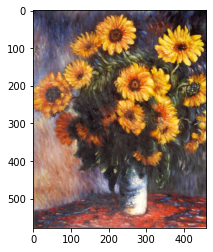

In [ ]:
# Стиль 1 - Картина Моне "Подсолнухи" 
plt.imshow(style_image1)
print(style_image1.size)

(486, 650)


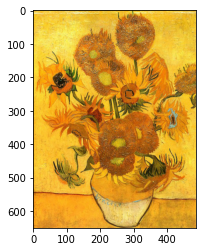

In [ ]:
# Стиль 2 - Картина Ван Гога "Подсолнухи" 
plt.imshow(style_image2)
print(style_image2.size)

Как видно, все эти изображения имеют разный размер, сделаем его одинаковым:

In [5]:
image_size = 300
image_transformer = transforms.Compose([
                                  transforms.Resize(image_size),
                                  transforms.CenterCrop(image_size)])
content_image_view = image_transformer(content_image)
input_image = image_transformer(input_image)
style_image1 = image_transformer(style_image1)
style_image2 = image_transformer(style_image2)

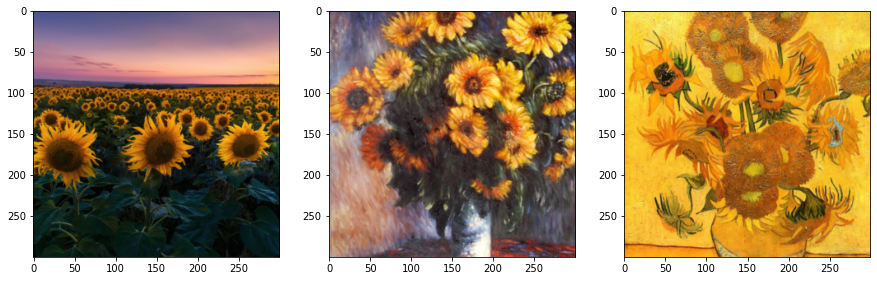

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,15)) 
ax[0].imshow(content_image_view)
ax[1].imshow(style_image1)
ax[2].imshow(style_image2)
plt.show()

Преобразуем изображения в тензоры:

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
image_transformer = transforms.ToTensor()
content_image = image_transformer(content_image_view).to(DEVICE)
input_image = image_transformer(input_image).to(DEVICE)
style_image1 = image_transformer(style_image1).to(DEVICE)
style_image2 = image_transformer(style_image2).to(DEVICE)

## 3. Простой перенос стиля.

Для начала я реализую обычный перенос стиля. 

Зададим функции потерь:

In [8]:
class ContentLoss(nn.Module):
        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            self.target = target.detach()
            self.loss = F.mse_loss(self.target, self.target)

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

In [9]:
def gram_matrix(input):
        batch_size, h, w, f_map_num = input.size() # h, w - dimensions of a feature map
        features = input.view(batch_size * h, w * f_map_num)
        G = torch.mm(features, features.t())
        return G.div(batch_size * h * w * f_map_num)

In [ ]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)

        def forward(self, input):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

В качестве модели возьмем VGG-19:

In [ ]:
vgg = models.vgg19(pretrained=True).features.to(DEVICE).eval()

Определим, после каких слоев будем считать функции потерь стиля и контента:

In [10]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

Так как в VGG-19 использовались нормализованные изображения, то наши изображения тоже нужно нормализовать ([источник](https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet/main.py#L197-L198)):

In [11]:
class Normalization(nn.Module):
        def __init__(self):
            super(Normalization, self).__init__()
            self.mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE).view(-1, 1, 1)
            self.std = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE).view(-1, 1, 1)

        def forward(self, img):
            return (img - self.mean) / self.std

Определим функцию построения модели:

In [ ]:
def get_model_and_losses(cnn, style_img, content_img, content_layers=content_layers, style_layers=style_layers):
        cnn = copy.deepcopy(cnn)
        normalization = Normalization().to(DEVICE)
        model = nn.Sequential(normalization)

        content_losses = []
        style_losses = []

        i = 0 
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False) # inplace does not work good with Content and Style losses
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
            model.add_module(name, layer)

            if name in content_layers:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        for i in range(len(model) - 1, -1, -1): # выбрасываем все уровни после последнего style или content loss
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

Добавим оптимизатор - будем выполнять градиентный спуск по пикселям изображения:

In [12]:
def get_input_optimizer(input_img):
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

Определим цикл обучения:

In [ ]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=500, style_weight=100000, content_weight=1):
        content_img = content_img.unsqueeze(0)
        style_img = style_img.unsqueeze(0)
        input_img = input_img.unsqueeze(0)
        model, style_losses, content_losses = get_model_and_losses(cnn, style_img, content_img)
        optimizer = get_input_optimizer(input_img)

        run = [0]
        while run[0] <= num_steps:
            def closure():
                # Эта функция предназначена для расчета функции потерь
                input_img.data.clamp_(0, 1)
                optimizer.zero_grad()
                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                style_score *= style_weight  # взвешивание ошибки
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
                    print()
                return style_score + content_score
            optimizer.step(closure)
        input_img.data.clamp_(0, 1)
        return input_img

Получим стилизованные изображения:

In [ ]:
output_style1 = run_style_transfer(vgg, content_image, style_image1, input_image, 500, 100000, 1)

run [50]:
Style Loss : 7.725450 Content Loss: 18.047075

run [100]:
Style Loss : 3.698420 Content Loss: 11.798576

run [150]:
Style Loss : 2.480335 Content Loss: 8.942499

run [200]:
Style Loss : 1.860618 Content Loss: 7.658534

run [250]:
Style Loss : 1.544299 Content Loss: 6.949271

run [300]:
Style Loss : 1.392787 Content Loss: 6.547616

run [350]:
Style Loss : 1.271566 Content Loss: 6.351783

run [400]:
Style Loss : 1.186818 Content Loss: 6.278723

run [450]:
Style Loss : 1.153507 Content Loss: 6.175421

run [500]:
Style Loss : 1.130363 Content Loss: 6.183983



In [ ]:
output_style2 = run_style_transfer(vgg, content_image, style_image2, input_image, 500, 100000, 1)

run [50]:
Style Loss : 24.129005 Content Loss: 30.945496

run [100]:
Style Loss : 4.450023 Content Loss: 18.303240

run [150]:
Style Loss : 2.754381 Content Loss: 12.632785

run [200]:
Style Loss : 2.084072 Content Loss: 10.028181

run [250]:
Style Loss : 1.665504 Content Loss: 8.801730

run [300]:
Style Loss : 1.445117 Content Loss: 8.151866

run [350]:
Style Loss : 1.249144 Content Loss: 7.702986

run [400]:
Style Loss : 1.128779 Content Loss: 7.460073

run [450]:
Style Loss : 1.126071 Content Loss: 7.396445

run [500]:
Style Loss : 1.149887 Content Loss: 7.212046



In [41]:
unloader = transforms.ToPILImage()
output_style1 = unloader(output_style1.detach().squeeze().to('cpu'))
output_style2 = unloader(output_style2.detach().squeeze().to('cpu'))

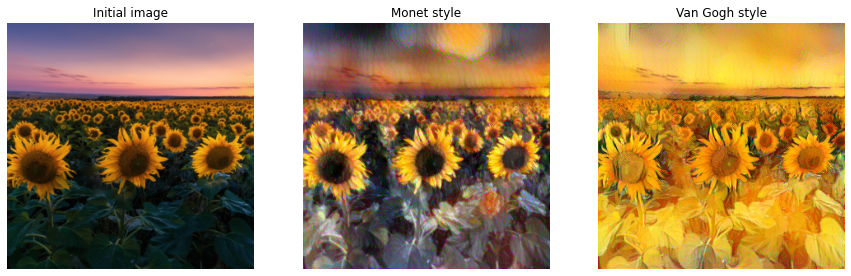

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(content_image_view)
ax[0].set_title('Initial image')
ax[0].axis('off')
ax[1].imshow(output_style1)
ax[1].set_title('Monet style')
ax[1].axis('off')
ax[2].imshow(output_style2)
ax[2].set_title('Van Gogh style')
ax[2].axis('off')
plt.show()

Сохраним получившиеся изображения на Google Drive:

In [ ]:
output_style1.save(os.path.join('/content/gdrive/MyDrive/DLS/NST/', 'monet_style.jpg'))
output_style2.save(os.path.join('/content/gdrive/MyDrive/DLS/NST/', 'van_gogh_style.jpg'))

## 4. Два стиля на двух половинах изображения.

Для этого задания нам понадобится маска (может быть какая угодно, возьмем самую простую - делящую изображение на две половины):

In [13]:
black_mask = np.ones([300, 150, 3], dtype=np.uint8) * 255
white_mask = np.zeros([300, 150, 3], dtype=np.uint8) * 255
mask = Image.fromarray(np.hstack((black_mask, white_mask)))
mask = mask.convert('L')

(300, 300)


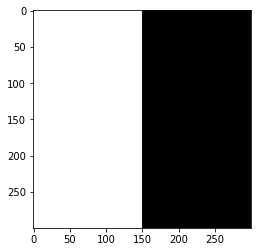

In [ ]:
plt.imshow(mask, cmap='gray')
print(mask.size)

In [14]:
mask = image_transformer(mask).to(DEVICE)

Будем использовать ту же модель:

In [15]:
vgg = models.vgg19(pretrained=True).features.to(DEVICE).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


Для этой задачи необходимо переписать функцию потерь для картинки-стиля:

In [35]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature1, target_feature2, mask, inverted_mask):
            super(StyleLoss, self).__init__()
            self.mask = mask.float()
            self.inverted_mask = inverted_mask.float()
            self.target_feature1 = target_feature1
            self.target_feature2 = target_feature2


            self.target1 = gram_matrix(self.target_feature1).detach()
            self.target2 = gram_matrix(self.target_feature2).detach()
            self.loss = (F.mse_loss(self.target1, self.target1) + F.mse_loss(self.target2, self.target2)) / 2

        def forward(self, input):
            # resize mask to feature map size
            fm_number = input.shape[1]
            mask_fm_number = self.mask.shape[0]
            if len(self.mask.shape) != 4:
              mask_transformer = transforms.Resize(input.shape[2])
              self.mask = mask_transformer(self.mask)
              self.mask = torch.cat(fm_number*[self.mask])
              self.mask = self.mask.unsqueeze(0)
              self.inverted_mask = mask_transformer(self.inverted_mask)
              self.inverted_mask = torch.cat(fm_number*[self.inverted_mask])
              self.inverted_mask = self.inverted_mask.unsqueeze(0)
            # get needed part of feature map
            self.target1 = gram_matrix(self.target_feature1 * self.mask).detach()
            self.target2 = gram_matrix(self.target_feature2 * self.inverted_mask).detach()
            gram_input1 = input * self.mask
            gram_input2 = input * self.inverted_mask
            G1 = gram_matrix(gram_input1)
            G2 = gram_matrix(gram_input2)
            self.loss = (F.mse_loss(G1, self.target1) + F.mse_loss(G2, self.target2)) / 2
            return input

Определим новую функцию построения модели:

In [38]:
def get_model_and_losses(cnn, style_img1, style_img2, content_img, mask, content_layers=content_layers, style_layers=style_layers):
        mask = mask.int()
        inverted_mask = (~mask.bool()).long()
        cnn = copy.deepcopy(cnn)
        normalization = Normalization().to(DEVICE)
        model = nn.Sequential(normalization)

        content_losses = []
        style_losses = []

        i = 0 
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False) # inplace does not work good with Content and Style losses
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
            model.add_module(name, layer)

            if name in content_layers:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)
          
            if name in style_layers:
                target_feature1 = model(style_img1).detach()
                target_feature2 = model(style_img2).detach()
                style_loss = StyleLoss(target_feature1, target_feature2, mask, inverted_mask)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        for i in range(len(model) - 1, -1, -1): # выбрасываем все уровни после последнего style или content loss
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

Определим новый цикл обучения:

In [37]:
def run_style_transfer(cnn, content_img, style_img1, style_img2, input_img, mask, num_steps=500, style_weight=100000, content_weight=1):
        torch.cuda.empty_cache()
        content_img = content_img.unsqueeze(0)
        style_img1 = style_img1.unsqueeze(0)
        style_img2 = style_img2.unsqueeze(0)
        input_img = input_img.unsqueeze(0)
        model, style_losses, content_losses = get_model_and_losses(cnn, style_img1, style_img2, content_img, mask)
        optimizer = get_input_optimizer(input_img)

        run = [0]
        while run[0] <= num_steps:
            def closure():
                # Эта функция предназначена для расчета функции потерь
                input_img.data.clamp_(0, 1)
                optimizer.zero_grad()
                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                style_score *= style_weight  # взвешивание ошибки
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
                    print()
                return style_score + content_score
            optimizer.step(closure)
            torch.cuda.empty_cache()
        input_img.data.clamp_(0, 1)
        return input_img

In [39]:
output_style3 = run_style_transfer(vgg, content_image, style_image1, style_image2, input_image, mask, 500, 100000, 1)

run [50]:
Style Loss : 7.803911 Content Loss: 8.506349

run [100]:
Style Loss : 2.514235 Content Loss: 6.816039

run [150]:
Style Loss : 1.660697 Content Loss: 6.291937

run [200]:
Style Loss : 1.422799 Content Loss: 5.901503

run [250]:
Style Loss : 1.432309 Content Loss: 6.154347

run [300]:
Style Loss : 1.343699 Content Loss: 5.728515

run [350]:
Style Loss : 1.428157 Content Loss: 5.878833

run [400]:
Style Loss : 1.331902 Content Loss: 5.346731

run [450]:
Style Loss : 1.255883 Content Loss: 5.199191

run [500]:
Style Loss : 1.372522 Content Loss: 5.754827



In [42]:
output_style3 = unloader(output_style3.detach().squeeze().to('cpu'))

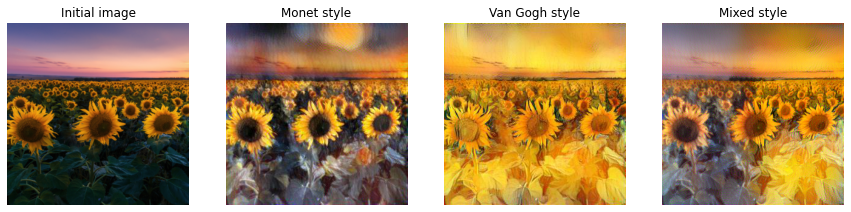

In [44]:
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
ax[0].imshow(content_image_view)
ax[0].set_title('Initial image')
ax[0].axis('off')
ax[1].imshow(output_style1)
ax[1].set_title('Monet style')
ax[1].axis('off')
ax[2].imshow(output_style2)
ax[2].set_title('Van Gogh style')
ax[2].axis('off')
ax[3].imshow(output_style3)
ax[3].set_title('Mixed style')
ax[3].axis('off')
plt.show()

Сохраним результат на Google Drive:

In [45]:
output_style3.save(os.path.join('/content/gdrive/MyDrive/DLS/NST/', 'mixed_style.jpg'))